## Imports

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib
matplotlib.use('Agg') #For unix use
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Read Data

In [2]:
#Set data path and read csv file 
dpath='./enron-event-history-all.csv'
columns_name=['time','message identifier','sender','recipients','topics','mode']
df=pd.read_csv(dpath,names=columns_name)
# Change to datetime type
df['time']=pd.to_datetime(df['time'],unit='ms')
#Check info of data to better understand this data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205731 entries, 0 to 205730
Data columns (total 6 columns):
time                  205731 non-null datetime64[ns]
message identifier    205731 non-null object
sender                205699 non-null object
recipients            205693 non-null object
topics                0 non-null float64
mode                  205731 non-null object
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 9.4+ MB


## Data Preparation

In [3]:
#Since topic is always empty and mode is always email, we can drop these two columns to simplify the dataframe
df.drop(['topics','mode'],axis=1,inplace=True)
#Then drop rows that both sender and recipients are null
df=df.dropna(subset=['sender', 'recipients'], how='all')
#Create a second dataframe to keep df as backup
df2 = pd.DataFrame()
df2['time'] = df['time']
df2['message identifier']=df['message identifier']
df2['sender'] = df['sender']
df2['recipients'] = df['recipients']

## Q1

In [4]:
#Create a empty list to store all recipients
Recipient_list= [] 
#Store all sender into the list
sender_list=list(df2.sender) 
#Use for loop to split the recipients and store all of them to the Recipient_list
for i in range(len(df2)):
    i_list=re.split('\|',str(df2['recipients'].values[i]))        
    Recipient_list.extend(i_list)
#Combine the sender and recipient lists and drop null value, then get a list with unique values
total_series=pd.Series(sender_list+Recipient_list)
total_list=total_series.dropna().unique().tolist()
#Remove the empty string or blank value
total_list.remove('blank')
total_list.remove('')

In [5]:
#Create a new dataframe to store sent info
sent_count = {'sent':'count'} 
df2['sent']=0
sent=df2.groupby('sender').agg(sent_count)
sent=sent.drop(index='blank') #Get rid of null value
sent=sent.reset_index() #Reset the index

In [6]:
#Create a new dataframe to store received info
recipient=pd.DataFrame(Recipient_list)
recipient.columns=['recipient']
recipient_count = {'received':'count'} 
recipient['received']=0
recipient2=recipient.groupby('recipient').agg(recipient_count)
recipient2=recipient2.drop(index='')  #Get rid of empty string
recipient2=recipient2.reset_index()

In [7]:
#Merge three dataframes on their common person names
total=pd.DataFrame() 
total['person']=total_list
total_df=pd.merge(total,sent,left_on='person',right_on='sender',how='outer')
total_df=pd.merge(total_df,recipient2,left_on='person',right_on='recipient',how='outer')
#Drop sender and recipient columns and save to the other dataframe
answer1=total_df.drop(['sender','recipient'],axis=1)
answer1.fillna(0,inplace=True)  #Fill null value with 0
answer1=answer1.astype({'sent': 'int32','received':'int32'})  #Change data type to integer
answer1=answer1.sort_values(by=['sent'],ascending=False).set_index('person')   #Sort by the number of emails sent and set index as person to keep only 3 columns
#Set output path and name and save the data as a csv file
answer1_output='./Part1_emailsummary.csv'
answer1.to_csv(answer1_output)

## Q2

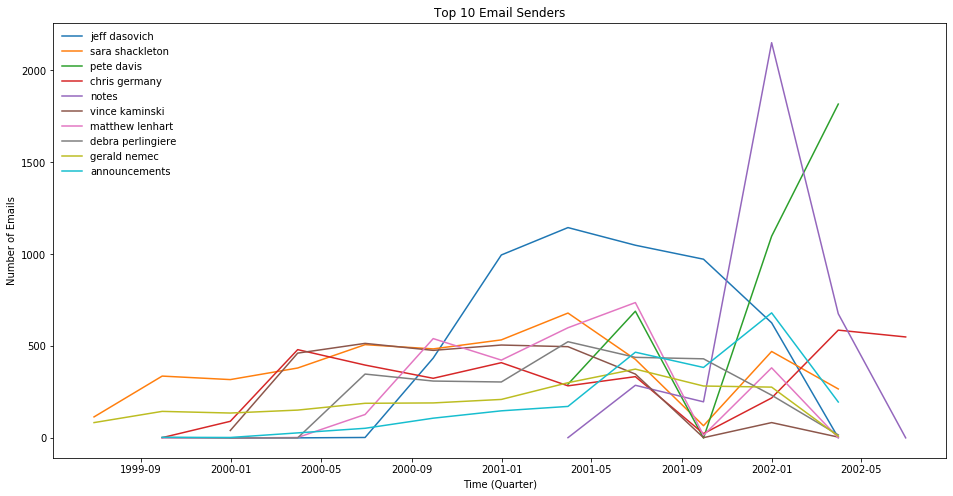

In [8]:
#Part 2 requires the output of the most prolific senders, so top 10 senders should be good 
part2=answer1.reset_index().head(10)
most_prolific_sender=part2['person']
plt.figure(figsize=(16,8))   #Set the figure size
#Use for loop to plot each of top 10 senders
for name in most_prolific_sender:
    time_sender=df2[df2['sender']==name][['time','sender']].set_index('time')  #Find the matched senders
    time_sender2=time_sender.resample('Q').count().reset_index()               #Resample the time by quarter and get total number of sent emails over time
    plt.plot(time_sender2['time'],time_sender2['sender'],label=name)          #Plot the line chart for time series data
#Set title and labels
plt.title('Top 10 Email Senders')
plt.legend(loc=2,frameon=False)
plt.xlabel('Time (Quarter)')
plt.ylabel('Number of Emails')
#Save the plot as png image
plt.savefig('Part2_Top10Senders.png',format='png',dpi=400)

## Q3

In [9]:
#Create a new dataframe that each row only holds one recipient
df3=df.dropna(subset=[ 'recipients']) #Drop null values in the recipients columns
re=df3.recipients.str.split("|")  #Split the recipients
t=np.repeat(df3.time.values,re.str.len())    
s=np.repeat(df3.sender.values,re.str.len())
re_concat=np.concatenate(re.values)
re_df=pd.DataFrame({'time':t,'sender':s,'recipients':re_concat})     

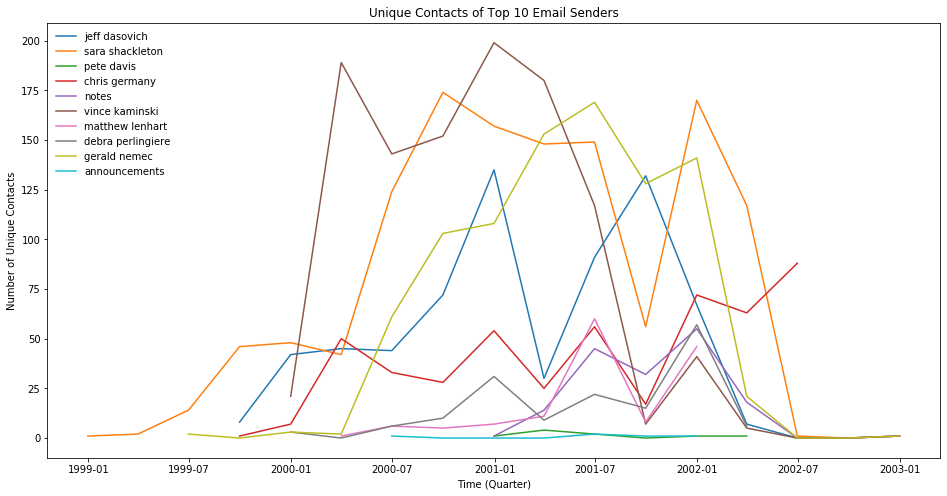

In [10]:
#Set the figure size
plt.figure(figsize=(16,8))  
#Keep using the same for loop as part 2
for name in most_prolific_sender:
    time_receive=re_df[re_df['recipients']==name][['time','sender','recipients']].set_index('time')  #Find the matched recipients
    time_receive2=time_receive.resample('Q').apply(lambda x: x.nunique()).reset_index()              #Resample the time and get number of unique values
    plt.plot(time_receive2['time'],time_receive2['sender'],label=name)                                #Plot the line chart
#Set title and labels
plt.title('Unique Contacts of Top 10 Email Senders')
plt.legend(loc=2,frameon=False)
plt.xlabel('Time (Quarter)')
plt.ylabel('Number of Unique Contacts')
#Save the plot as png image
plt.savefig('Part3_UniqueContacts.png',format='png',dpi=400)